# Estimativa preços de venda do dataset Boston_housing

Um dos problemas clássicos de machine learning é a previsão dos preços das casas de Boston apresentado no final da década de 1970.

Existe uma competição no Kaggle que utiliza este dataset:
https://www.kaggle.com/c/boston-housing

O objetivo desse notebook é fazer a previsão dos preços das casas utilizando uma rede neural com algumas camadas escondidas.


## Importação dos pacotes

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import MultiStepLR, StepLR
from torch.autograd import Variable

import lib.pytorch_trainer as ptt

use_gpu = torch.cuda.is_available()
print('GPU available:', use_gpu)

GPU available: False


## Leitura do Dataset

Leitura do Dataset já normalizado: [boston_housing.ipynb](boston_housing.ipynb)
- **Atenção**: se houver erro em não achar o arquivo, executar o notebook boston_housing.ipynb

In [2]:
datain = np.load('../data/boston_housing_normalize.npz')

x, y = datain['Xtra'], datain['ytra']

In [3]:
n_samples, n_attributes = x.shape
print('n_samples:', n_samples)
print('n_attributes:', n_attributes)

n_samples: 506
n_attributes: 13


### Conversão para Tensor

In [4]:
x_train = torch.FloatTensor(x)
y_train = torch.FloatTensor(y)

## Rede

In [43]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.layer1 = nn.Linear(n_attributes, 64)
        self.ativ1  = nn.SELU()
        self.layer2 = nn.Linear(64, 64)
        self.ativ2  = nn.SELU()
        self.layer3 = nn.Linear(64, 64)
        self.ativ3  = nn.SELU()
        self.layer4 = nn.Linear(64, 1)

    def forward(self, x):
        x = self.layer1(x)
        x = self.ativ1(x)
        x = nn.functional.dropout(x)
        x = self.layer2(x)
        x = self.ativ2(x)
        x = nn.functional.dropout(x)
        x = self.layer3(x)
        x = self.ativ3(x)
        x = nn.functional.dropout(x)
        x = self.layer4(x)
        return x

model = Model()
if use_gpu:
    model.cuda()
model

Model(
  (layer1): Linear(in_features=13, out_features=64)
  (ativ1): SELU
  (layer2): Linear(in_features=64, out_features=64)
  (ativ2): SELU
  (layer3): Linear(in_features=64, out_features=64)
  (ativ3): SELU
  (layer4): Linear(in_features=64, out_features=1)
)

## Parâmetros do otimizador

A escolha dos parâmetros para o treinamento é crítica. A escolha do learning rate,
do método de ótimização, do tamanho do mini-batch, do número de camadas, do número de neurônios em
cada camada, são todas críticas para o sucesso do estimador.

In [44]:
criterion = nn.MSELoss()
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.0005, alpha=0.7)
savebest = ptt.ModelCheckpoint('../../models/bostonhousing',reset=True, verbose=1)

trainer = ptt.DeepNetTrainer(
        model =         model,
        criterion =     criterion,
        optimizer =     optimizer,
        callbacks =     [savebest,ptt.PrintCallback()]
        )

## Treinamento

In [45]:
trainer.fit(50, x_train, y_train, valid_split=0.2, shuffle=True, batch_size=2)

Start training for 50 epochs
  1:   0.3s   T: 314.63419   V: 14.65629 best
  2:   0.2s   T: 40.20692   V: 12.29823 best
  3:   0.2s   T: 34.65493   V: 11.68305 best
  4:   0.2s   T: 33.16625   V: 15.13483 
  5:   0.2s   T: 29.59808   V: 10.92019 best
  6:   0.2s   T: 28.39095   V: 9.99010 best
  7:   0.2s   T: 26.10730   V: 9.31546 best
  8:   0.2s   T: 25.27871   V: 9.35992 
  9:   0.2s   T: 23.41432   V: 11.02827 
 10:   0.2s   T: 22.82379   V: 8.34695 best
 11:   0.2s   T: 21.60992   V: 7.85531 best
 12:   0.2s   T: 21.15993   V: 7.72072 best
 13:   0.2s   T: 20.49793   V: 7.94430 
 14:   0.2s   T: 20.16572   V: 7.39360 best
 15:   0.2s   T: 19.72098   V: 7.34859 best
 16:   0.2s   T: 18.57602   V: 6.70086 best
 17:   0.2s   T: 18.07237   V: 8.40427 
 18:   0.2s   T: 17.51771   V: 7.43133 
 19:   0.2s   T: 17.76988   V: 7.45629 
 20:   0.2s   T: 17.47335   V: 7.54223 
 21:   0.2s   T: 17.45758   V: 10.91012 
 22:   0.2s   T: 17.25955   V: 7.21366 
 23:   0.2s   T: 16.84137   V: 7.80

## Avaliação

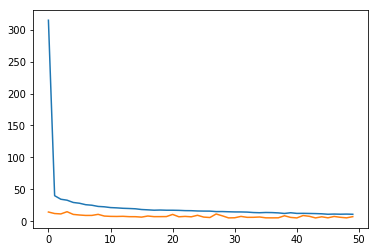

In [46]:
train_loss = trainer.metrics['train']['losses']
valid_loss = trainer.metrics['valid']['losses']
epochs = np.arange(len(train_loss))
plt.plot(epochs, train_loss,
         epochs, valid_loss)

In [47]:
trainer.load_state('../../models/bostonhousing')

In [48]:
eval = trainer.evaluate(x_train,y_train)
eval

evaluate: 50/50 ok


{'losses': 9.966361235959727}

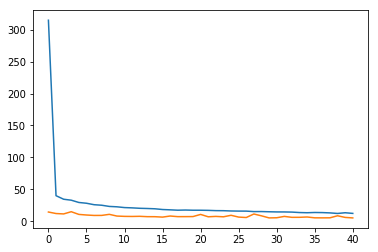

In [49]:
train_loss = trainer.metrics['train']['losses']
valid_loss = trainer.metrics['valid']['losses']
epochs = np.arange(len(train_loss))
plt.plot(epochs, train_loss,
         epochs, valid_loss)

In [50]:
print('MSE:',valid_loss[-1])
print('RMSE:', np.sqrt(valid_loss[-1]))

MSE: 5.439531635087316
RMSE: 2.33228035088


# Exercícios

- Troque os hyperparâmetros para verificar se você consegue obter valores melhores. A forma de
  escolha e alteração de parâmetros é algo que se aprende com a experiência. Procure fazer
  sintonias finas, variando apenas um ou poucos parâmetros de cada vez.
  
  Parâmetros que podem ser trocados:
  - learning rate
  - n. de camadas
  - n. de neurônios
  - troca de função de ativação
  - método de otimizador do gradiente descendente
